In [7]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from shared_functions import update_accuracy_in_config
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:

# Load your dataset
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to numerical data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


In [9]:

def select_features_chi2(X_train, y_train, X_test, k=1000):
    """
    Select top k features using Chi-Square test for feature selection.
    
    Args:
        X_train (array-like): Training data features.
        y_train (array-like): Training data labels.
        X_test (array-like): Test data features.
        k (int): Number of top features to select. Default is 1000.
    
    Returns:
    """
    chi2_selector = SelectKBest(chi2, k=k)
    X_train_selected = chi2_selector.fit_transform(X_train, y_train)
    X_test_selected = chi2_selector.transform(X_test)
    return chi2_selector, X_train_selected, X_test_selected

def train_and_evaluate(X_train, X_test, y_train, y_test, feature_selector):
    """
    Train and evaluate a Naive Bayes model with feature selection.
    
    Args:
        X_train (array-like): Training data features.
        X_test (array-like): Test data features.
        y_train (array-like): Training data labels.
        y_test (array-like): Test data labels.
        feature_selector (function): Function for feature selection that returns selector and transformed data.
       """
    # Feature selection
    selector, X_train_selected, X_test_selected = feature_selector(X_train, y_train, X_test)
    
    # Train Naive Bayes model
    model = MultinomialNB()
    model.fit(X_train_selected, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    # Save the model, vectorizer, and selector to a pickle file
    joblib.dump((vectorizer, model, selector), '../trained_models/NB_TF.pkl')

    # Update accuracy in the config file
    update_accuracy_in_config(accuracy, 'tfidf_naivebase')
    
    return model, vectorizer, selector, accuracy, y_pred

# Perform feature selection and model training
feature_selector = lambda X_train, y_train, X_test: select_features_chi2(X_train, y_train, X_test, k=1000)
model, vectorizer, selector, accuracy , y_pred = train_and_evaluate(X_train_vect, X_test_vect, y_train, y_test, feature_selector)


Accuracy: 0.7755555555555556
Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.74      0.82       162
        fear       0.86      0.75      0.80       151
         joy       0.85      0.58      0.69       148
        love       0.67      0.93      0.78       143
     sadness       0.69      0.72      0.71       141
    surprise       0.75      0.93      0.83       155

    accuracy                           0.78       900
   macro avg       0.79      0.78      0.77       900
weighted avg       0.79      0.78      0.77       900



In [10]:


# Predicting new sentences
sentences = [
    "I love programming and data science.",
    "The weather is terrible today.",
    "Let's have a meeting to discuss the project."
]

# Convert new sentences to numerical data
sentences_vect = vectorizer.transform(sentences)

# Apply feature selection to new sentences
sentences_selected = selector.transform(sentences_vect)

# Predict using the trained model
predictions = model.predict(sentences_selected)

for sentence, prediction in zip(sentences, predictions):
    print(f'Sentence: "{sentence}"')
    print(f'Predicted Label: {prediction}')
    print()



print("Model saved to NB_TF.pkl")


Sentence: "I love programming and data science."
Predicted Label: love

Sentence: "The weather is terrible today."
Predicted Label: sadness

Sentence: "Let's have a meeting to discuss the project."
Predicted Label: fear

Model saved to NB_TF.pkl


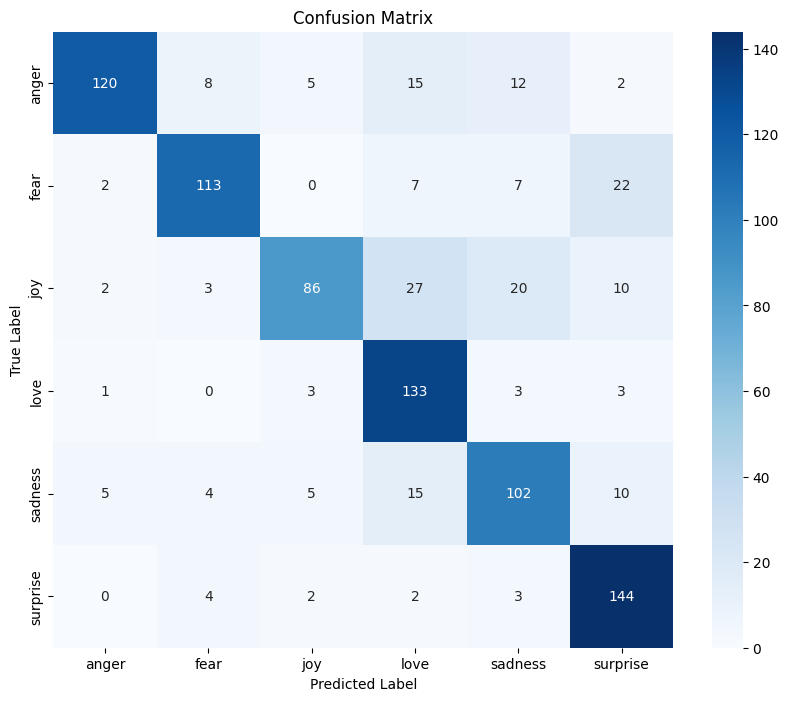

In [11]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plot the confusion matrix using seaborn heatmap.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels by the model.
        labels (list): List of class labels for the confusion matrix.

    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example usage
labels = df['label'].unique()  # Extract unique labels from the DataFrame
plot_confusion_matrix(y_test, y_pred, labels)